## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from neural_networks.seg_reg_net import SegRegNet
from neural_networks.keras_utils import EvalMetricsCallback
from utils.data.data_augmentation import augment16_from_dir_and_save
from utils.data.data_generator import DataGenerator
from utils.data.data_ops import move_val_split_to_train
from utils.data.data_ops import create_val_split_from_train
from utils.input_output.io import read_json, write_json
from utils.visualization.vis import plot_logs, plot_seg_reg_maps

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load the dataset

#### Create validation split from the initial training data

In [4]:
'''
move_val_split_to_train(config.VAL_PATH, config.TRAIN_PATH)
create_val_split_from_train(config.TRAIN_PATH, config.VAL_PATH, config.VAL_SIZE, config.RAND_SEED)
'''

'\nmove_val_split_to_train(config.VAL_PATH, config.TRAIN_PATH)\ncreate_val_split_from_train(config.TRAIN_PATH, config.VAL_PATH, config.VAL_SIZE, config.RAND_SEED)\n'

#### Data augmentation (train/val split)

In [5]:
'''
augment16_from_dir_and_save(in_path=config.TRAIN_PATH,
                            save_path=config.TRAIN_PATH,
                            rseed=config.RAND_SEED)

augment16_from_dir_and_save(in_path=config.VAL_PATH,
                            save_path=config.VAL_PATH,
                            rseed=config.RAND_SEED + 1)
'''

'\naugment16_from_dir_and_save(in_path=config.TRAIN_PATH,\n                            save_path=config.TRAIN_PATH,\n                            rseed=config.RAND_SEED)\n\naugment16_from_dir_and_save(in_path=config.VAL_PATH,\n                            save_path=config.VAL_PATH,\n                            rseed=config.RAND_SEED + 1)\n'

#### Data generators

In [6]:
train_params = {
    'dim': config.PATCH_DIM,
    'batch_size': config.BATCH_SIZE,
    'patches_per_image': config.PATCHES_PER_IMAGE,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': config.SHUFFLE,
    'ignored_images': config.IGNORED_IMAGES,
    'data_augmentation': True,
    'output_mode': 'seg_reg',
    'gt_seg_thr': config.GT_SEG_THR
}

val_params = {
    'dim': config.IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': False,
    'data_augmentation': True,
    'output_mode': 'seg_reg',
    'gt_seg_thr': config.GT_SEG_THR
}

In [7]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **train_params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **val_params)

## 3. Instantiate a SegRegNet

In [8]:
model = SegRegNet(seg_loss_name=config.SEG_LOSS_NAME,
                  reg_loss_name=config.REG_LOSS_NAME,
                  loss_weights=[1, 0],
                  learning_rate=config.LEARNING_RATE)

## 4. Train the model

In [9]:
!rm -rf $config.CHECKPOINTS_PATH
!rm -rf $config.LOGS_PATH
os.makedirs(config.CHECKPOINTS_PATH)
os.makedirs(config.LOGS_PATH)

### Seg training

In [10]:
%%time
model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   save_best_only=True)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.SEG_EPOCHS,
                                    callbacks=[model_checkpoint],
                                    verbose=1)

Epoch 1/25
1276/1276 [==============================] - 1237s 969ms/step - loss: 0.2624 - activation_1_loss: 0.2624 - conv2d_12_loss: 0.3381 - val_loss: 0.2443 - val_activation_1_loss: 0.2443 - val_conv2d_12_loss: 0.2921
Epoch 2/25
1276/1276 [==============================] - 1231s 965ms/step - loss: 0.2180 - activation_1_loss: 0.2180 - conv2d_12_loss: 0.1965 - val_loss: 0.2207 - val_activation_1_loss: 0.2207 - val_conv2d_12_loss: 0.2577
Epoch 3/25
1276/1276 [==============================] - 1239s 971ms/step - loss: 0.1941 - activation_1_loss: 0.1941 - conv2d_12_loss: 0.1839 - val_loss: 0.1961 - val_activation_1_loss: 0.1961 - val_conv2d_12_loss: 0.2459
Epoch 4/25
1276/1276 [==============================] - 1231s 965ms/step - loss: 0.1767 - activation_1_loss: 0.1767 - conv2d_12_loss: 0.1740 - val_loss: 0.1843 - val_activation_1_loss: 0.1843 - val_conv2d_12_loss: 0.2454
Epoch 5/25
1276/1276 [==============================] - 1238s 970ms/step - loss: 0.1695 - activation_1_loss: 0.1695 

#### Save and load train stats/logs/history

In [11]:
def save_logs(model):
    logs = model.history.history.copy()

    logs['train_loss'] = logs.pop('loss')
    logs['train_size'] = train_generator.get_size()
    logs['val_size'] = val_generator.get_size()
    logs['rand_seed'] = config.RAND_SEED
    logs['shuffle'] = config.SHUFFLE
    logs['seg_loss_name'] = config.SEG_LOSS_NAME
    logs['reg_loss_name'] = config.REG_LOSS_NAME
    logs['img_dim'] = config.IMG_DIM
    logs['patch_dim'] = config.PATCH_DIM
    logs['patches_per_image'] = config.PATCHES_PER_IMAGE
    logs['density_map_sigma'] = config.GT_SIGMA
    logs['density_map_multiplication_factor'] = config.DENSITY_MAP_MULTIPLICATION_FACTOR
    logs['sub_experiment_name'] = config.SUB_EXPERIMENT_NAME
    logs['architecture'] = config.ARCHITECTURE_NAME
    
    return logs

min val_loss: 0.1227, epoch: 23


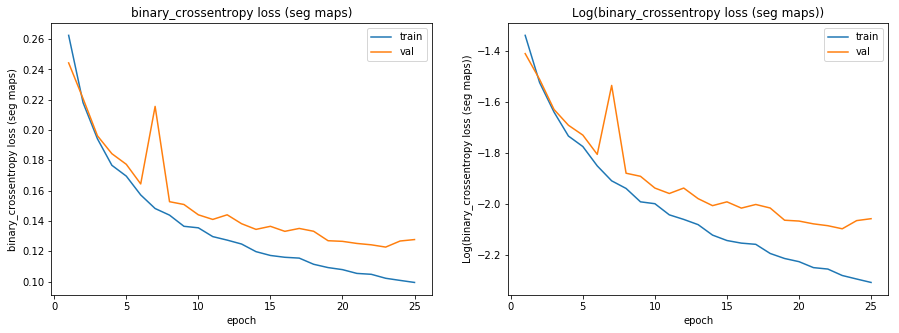

In [12]:
seg_logs = save_logs(model)
write_json(seg_logs, config.SEG_LOGS_FILENAME)
seg_logs = read_json(config.SEG_LOGS_FILENAME)

print(f'min val_loss: {np.min(seg_logs["val_loss"]):.4f}, epoch: {1 + np.argmin(seg_logs["val_loss"])}')

plot_logs(seg_logs['train_loss'], seg_logs['val_loss'], f'{config.SEG_LOSS_NAME} loss (seg maps)')

#### Load the best model

In [13]:
model = SegRegNet(seg_loss_name=config.SEG_LOSS_NAME,
                  reg_loss_name=config.REG_LOSS_NAME,
                  loss_weights=[1, 0],
                  learning_rate=config.LEARNING_RATE,
                  pretrained_weights=config.CHECKPOINT_FILENAME)

#### Look at one example from the validation set

In [14]:
img, (gt_seg_map, gt_density_map) = val_generator.__getitem__(1)
pred_seg_map, pred_density_map = model.predict(img)

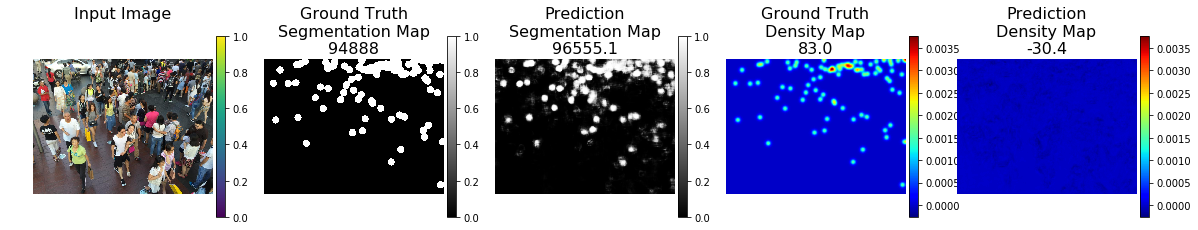

In [15]:
plot_seg_reg_maps(img.squeeze(), gt_seg_map, pred_seg_map, gt_density_map, pred_density_map,
                  config.DENSITY_MAP_MULTIPLICATION_FACTOR)

#### Set trainable=False for all layers of encoder

In [16]:
for idx in range(8):
    model.layers[idx].trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f271faa9d68> False
<keras.layers.convolutional.Conv2D object at 0x7f271faa9dd8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f270cedaf28> False
<keras.layers.convolutional.Conv2D object at 0x7f270cedafd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f271dc28a58> False
<keras.layers.convolutional.Conv2D object at 0x7f271dbe8710> False
<keras.layers.pooling.MaxPooling2D object at 0x7f271dc0f438> False
<keras.layers.convolutional.Conv2D object at 0x7f271dc0f2e8> False
<keras.layers.convolutional.UpSampling2D object at 0x7f271db75eb8> True
<keras.layers.convolutional.Conv2D object at 0x7f271db75160> True
<keras.layers.convolutional.UpSampling2D object at 0x7f271daba400> True
<keras.layers.convolutional.UpSampling2D object at 0x7f271db30780> True
<keras.layers.convolutional.Conv2D object at 0x7f271dabaa90> True
<keras.layers.convolutional.Conv2D object at 0x7f271db30390> True
<keras.layers.convolutional.UpSampling2D object 

### Reg training

#### Prepare the model for the training

In [17]:
model.compile(optimizer=Adam(lr=config.LEARNING_RATE),
              loss=[config.SEG_LOSS_NAME, config.REG_LOSS_NAME],
              loss_weights=[0, 1])

#### Training time

In [18]:
%%time
model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME_VAR,
                                   monitor='val_loss',
                                   save_best_only=False)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.REG_EPOCHS,
                                    callbacks=[model_checkpoint],
                                    verbose=1)

Epoch 1/50
1276/1276 [==============================] - 1070s 839ms/step - loss: 0.0807 - activation_2_loss: 0.1008 - conv2d_24_loss: 0.0807 - val_loss: 0.1184 - val_activation_2_loss: 0.1227 - val_conv2d_24_loss: 0.1184
Epoch 2/50
1276/1276 [==============================] - 1058s 829ms/step - loss: 0.0718 - activation_2_loss: 0.1013 - conv2d_24_loss: 0.0718 - val_loss: 0.1061 - val_activation_2_loss: 0.1227 - val_conv2d_24_loss: 0.1061
Epoch 3/50
1276/1276 [==============================] - 1058s 829ms/step - loss: 0.0675 - activation_2_loss: 0.1006 - conv2d_24_loss: 0.0675 - val_loss: 0.1047 - val_activation_2_loss: 0.1227 - val_conv2d_24_loss: 0.1047
Epoch 4/50
1276/1276 [==============================] - 1057s 828ms/step - loss: 0.0662 - activation_2_loss: 0.1009 - conv2d_24_loss: 0.0662 - val_loss: 0.1010 - val_activation_2_loss: 0.1227 - val_conv2d_24_loss: 0.1010
Epoch 5/50
1276/1276 [==============================] - 1057s 829ms/step - loss: 0.0679 - activation_2_loss: 0.1012 

Epoch 38/50
1276/1276 [==============================] - 1053s 825ms/step - loss: 0.0550 - activation_2_loss: 0.1006 - conv2d_24_loss: 0.0550 - val_loss: 0.0993 - val_activation_2_loss: 0.1227 - val_conv2d_24_loss: 0.0993
Epoch 39/50
1276/1276 [==============================] - 1054s 826ms/step - loss: 0.0545 - activation_2_loss: 0.1008 - conv2d_24_loss: 0.0545 - val_loss: 0.0953 - val_activation_2_loss: 0.1227 - val_conv2d_24_loss: 0.0953
Epoch 40/50
1276/1276 [==============================] - 1057s 828ms/step - loss: 0.0560 - activation_2_loss: 0.0999 - conv2d_24_loss: 0.0560 - val_loss: 0.0956 - val_activation_2_loss: 0.1227 - val_conv2d_24_loss: 0.0956
Epoch 41/50
1276/1276 [==============================] - 1055s 827ms/step - loss: 0.0541 - activation_2_loss: 0.1005 - conv2d_24_loss: 0.0541 - val_loss: 0.0970 - val_activation_2_loss: 0.1227 - val_conv2d_24_loss: 0.0970
Epoch 42/50
1276/1276 [==============================] - 1055s 826ms/step - loss: 0.0544 - activation_2_loss: 0.

min val_loss: 0.0942, epoch: 36


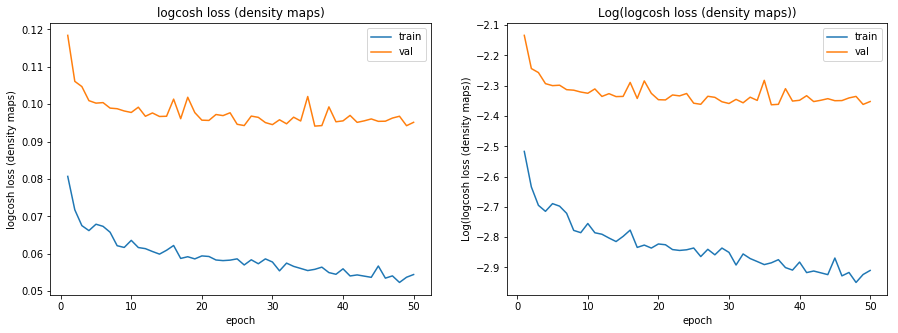

In [19]:
reg_logs = save_logs(model)
write_json(reg_logs, config.REG_LOGS_FILENAME)
reg_logs = read_json(config.REG_LOGS_FILENAME)

print(f'min val_loss: {np.min(reg_logs["val_loss"]):.4f}, epoch: {1 + np.argmin(reg_logs["val_loss"])}')

plot_logs(reg_logs['train_loss'], reg_logs['val_loss'], f'{config.REG_LOSS_NAME} loss (density maps)')

#### Load the best model (model.18 in this case)

In [23]:
!ls $config.CHECKPOINTS_PATH

best_model.hdf5      model.17-0.096.hdf5  model.34-0.096.hdf5
model.01-0.118.hdf5  model.18-0.102.hdf5  model.35-0.102.hdf5
model.02-0.106.hdf5  model.19-0.098.hdf5  model.36-0.094.hdf5
model.03-0.105.hdf5  model.20-0.096.hdf5  model.37-0.094.hdf5
model.04-0.101.hdf5  model.21-0.096.hdf5  model.38-0.099.hdf5
model.05-0.100.hdf5  model.22-0.097.hdf5  model.39-0.095.hdf5
model.06-0.100.hdf5  model.23-0.097.hdf5  model.40-0.096.hdf5
model.07-0.099.hdf5  model.24-0.098.hdf5  model.41-0.097.hdf5
model.08-0.099.hdf5  model.25-0.095.hdf5  model.42-0.095.hdf5
model.09-0.098.hdf5  model.26-0.094.hdf5  model.43-0.096.hdf5
model.10-0.098.hdf5  model.27-0.097.hdf5  model.44-0.096.hdf5
model.11-0.099.hdf5  model.28-0.096.hdf5  model.45-0.095.hdf5
model.12-0.097.hdf5  model.29-0.095.hdf5  model.46-0.095.hdf5
model.13-0.098.hdf5  model.30-0.095.hdf5  model.47-0.096.hdf5
model.14-0.097.hdf5  model.31-0.096.hdf5  model.48-0.097.hdf5
model.15-0.097.hdf5  model.32-0.095.hdf5  model.49-0.094.hdf5
model.16

In [27]:
model = SegRegNet(seg_loss_name=config.SEG_LOSS_NAME,
                  reg_loss_name=config.REG_LOSS_NAME,
                  loss_weights=[1, 0],
                  learning_rate=config.LEARNING_RATE,
                  pretrained_weights=f'{config.CHECKPOINTS_PATH}/model.18-0.102.hdf5')

#### Look at one example from the validation set

In [28]:
img, (gt_seg_map, gt_density_map) = val_generator.__getitem__(1)
pred_seg_map, pred_density_map = model.predict(img)

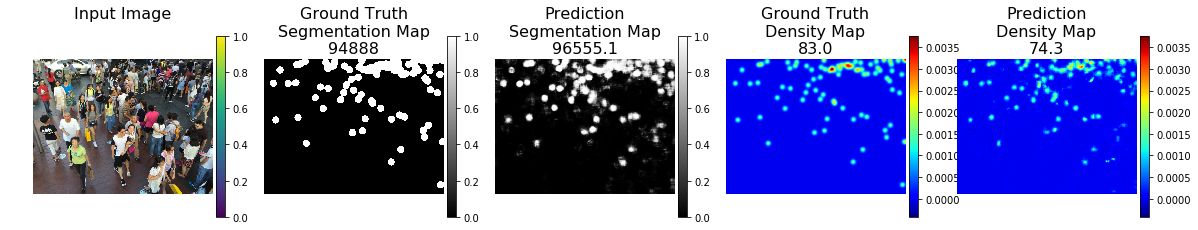

In [29]:
plot_seg_reg_maps(img.squeeze(), gt_seg_map, pred_seg_map, gt_density_map, pred_density_map,
                  config.DENSITY_MAP_MULTIPLICATION_FACTOR)